# Student-t location



In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import jax.random as random
import models.loc_student as mod
from validation import run_single_comparison
from kde_ref.posterior import get_normalized_posterior_pdf

## Parameters

In [ ]:
n = 50
k = 3.0
mu_true = 2.0
T_gibbs = 50000
T_mh = 50000
T_kde = 50000
burnin = 1000
seed = 0
cache_dir = "../cache"

# Prior: N(prior_mean, prior_std^2). Change prior_std to modify prior variance.
prior_mean = 0.0
prior_std = 3.0
# KDE bandwidth: "scott", "silverman", or a float (e.g. 0.001 for Student-t heavy tails).
kde_bw_method = "silverman"
bw_method = "scott"
# Gibbs RW proposal: std of the Random Walk for mu and for z (x-update). Tune to get acceptance ~20-40%.
proposal_std_mu = 1.
proposal_std_z = 1.
base_params = {"prior_mean": prior_mean, "prior_std": prior_std, "kde_bw_method": kde_bw_method,
              "proposal_std_mu": proposal_std_mu, "proposal_std_z": proposal_std_z}

params = {"n": n, "k": k, "mu_true": mu_true, "proposal_std_mu": proposal_std_mu, "proposal_std_z": proposal_std_z, "prior_mean": prior_mean, "prior_std": prior_std}
key = random.PRNGKey(seed)

## Sample Data

In [3]:
key, subkey = random.split(key)
data = mod.sample_data(subkey, params, loc = mu_true)
mle = mod.get_mle(data, params)
print(f"Data: min {data.min():.2f}, max {data.max():.2f}, mean {data.mean():.2f}, std {data.std():.2f}")
print(f"MLE: {mle:.2f}")

Data: min -0.39, max 4.43, mean 2.08, std 1.30
MLE: 1.98


## Run Gibbs

In [4]:
key, key_gibbs = random.split(key)
print(f"Running Gibbs...")
params["num_iterations_T"] = T_gibbs
gibbs_results = mod.run_gibbs(key_gibbs, float(mle), params)
print(f"Gibbs acceptance rates: mu={gibbs_results['mu_acceptance_rate']:.2%}, pair={gibbs_results['pair_acceptance_rate']:.2%}, z={gibbs_results['z_acceptance_rate']:.2%}")
print(f"Gibbs chain(burnin={burnin}): min={gibbs_results['mu_chain'].min():.2f}, max={gibbs_results['mu_chain'].max():.2f}, mean={gibbs_results['mu_chain'].mean():.2f}, std={gibbs_results['mu_chain'].std():.2f}")

Running Gibbs...


Gibbs (Student): 100%|██████████| 10000/10000 [01:20<00:00, 123.82it/s]


Gibbs acceptance rates: mu=42.00%, pair=100.00%, z=64.50%
Gibbs chain(burnin=1000): min=0.28, max=3.64, mean=1.92, std=0.41


## Run KDE Trick

In [5]:
key, subkey = random.split(key)
params["kde_bw_method"] = "SJ_transform"
mle_samples = mod.get_benchmark_mle_samples(subkey, params, num_simulations=T_kde, verbose=True)
kde_posterior_pdf = get_normalized_posterior_pdf(mle, params, mle_samples, verbose=True)


Fitting asinh+SJ KDE: s=None, gridsize=8192


## Run MH on full data

In [6]:
key, subkey = random.split(key)
mh_results = mod.run_full_data_mh(subkey, data, params)
T_mh = 100000
params["num_iterations_fulldata"] = T_mh
print(f"MH acceptance rate: {mh_results['mu_acceptance_rate']:.2%}")
print(f"MH chain(burnin={burnin}): min={mh_results['mu_chain'].min():.2f}, max={mh_results['mu_chain'].max():.2f}, mean={mh_results['mu_chain'].mean():.2f}, std={mh_results['mu_chain'].std():.2f}")

Full-data MH (Student): 100%|██████████| 10000/10000 [00:23<00:00, 425.89it/s]

MH acceptance rate: 40.85%
MH chain(burnin=1000): min=0.49, max=3.44, mean=1.97, std=0.38


## Overlay: densities of the three posteriors

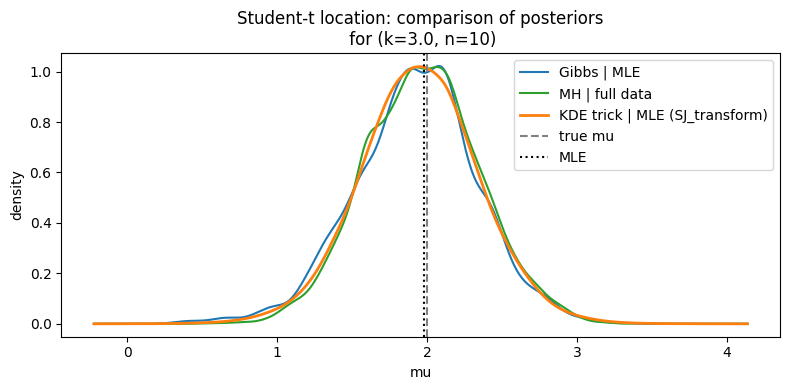

In [12]:
thin = 1
mu_gibbs = gibbs_results["mu_chain"][burnin::thin]
mu_fulldata = mh_results["mu_chain"][burnin::thin]
kde_pdf = kde_posterior_pdf

lo = min(mu_gibbs.min(), mu_fulldata.min()) - 0.5
hi = max(mu_gibbs.max(), mu_fulldata.max()) + 0.5
mu_grid = np.linspace(lo, hi, 500)
kde_vals = np.maximum(kde_pdf(mu_grid), 1e-20)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
kde_gibbs = gaussian_kde(mu_gibbs, bw_method="scott")
kde_fulldata = gaussian_kde(mu_fulldata, bw_method="scott")
ax.plot(mu_grid, kde_gibbs(mu_grid), color="C0", label="Gibbs | MLE")
ax.plot(mu_grid, kde_fulldata(mu_grid), color="C2", label="MH | full data")
ax.plot(mu_grid, kde_vals, color="C1", lw=2, label=f"KDE trick | MLE ({params['kde_bw_method']})")
ax.axvline(mu_true, color="gray", ls="--", label="true mu")
ax.axvline(mle, color="black", ls=":", label="MLE")
ax.set_xlabel("mu")
ax.set_ylabel("density")
ax.legend()
ax.set_title(f"Student-t location: comparison of posteriors\n for (k={k}, n={n})")
plt.tight_layout()
plt.show()

## Trace plots (Gibbs and full-data MH)

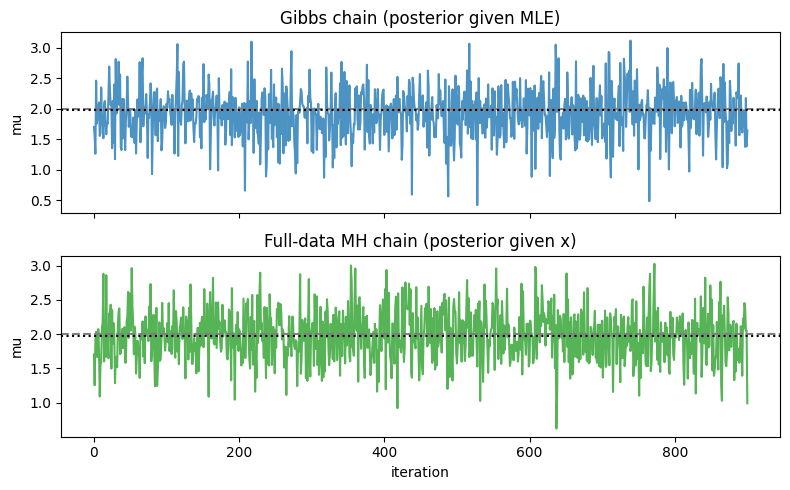

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
axes[0].plot(mu_gibbs, color = "C0", alpha=0.8)
axes[0].set_ylabel("mu")
axes[0].set_title("Gibbs chain (posterior given MLE)")
axes[0].axhline(mu_true, color="gray", ls="--")
axes[0].axhline(mle, color="black", ls=":", label="MLE")
axes[1].plot(mu_fulldata, color="C2", alpha=0.8)
axes[1].set_ylabel("mu")
axes[1].set_xlabel("iteration")
axes[1].set_title("Full-data MH chain (posterior given x)")
axes[1].axhline(mu_true, color="gray", ls="--")
axes[1].axhline(mle, color="black", ls=":", label="MLE")
plt.tight_layout()
plt.show()

## DEBUG: KDE Trick

In [9]:
params["kde_bw_method"] = "scott"
kde_posterior_pdf_scott = get_normalized_posterior_pdf(mle, params, mle_samples, verbose=True)
params["kde_bw_method"] = "silverman"
kde_posterior_pdf_silverman = get_normalized_posterior_pdf(mle, params, mle_samples, verbose=True)
params["kde_bw_method"] = 1.0
kde_posterior_pdf_1 = get_normalized_posterior_pdf(mle, params, mle_samples, verbose=True)
params["kde_bw_method"] = 0.1
kde_posterior_pdf_01 = get_normalized_posterior_pdf(mle, params, mle_samples, verbose=True)
params["kde_bw_method"] = 0.01
kde_posterior_pdf_001 = get_normalized_posterior_pdf(mle, params, mle_samples, verbose=True)
params["kde_bw_method"] = 0.001
kde_posterior_pdf_0001 = get_normalized_posterior_pdf(mle, params, mle_samples, verbose=True)
# params["kde_bw_method"] = "t_abram"
# kde_posterior_t_abram = get_normalized_posterior_pdf(mle, params, mle_samples, verbose=True)
params["kde_bw_method"] = "SJ_transform"
kde_posterior_sj_transform = get_normalized_posterior_pdf(mle, params, mle_samples, verbose=True)

Fitting Gaussian KDE on MLE samples using bw_method = scott
Fitting Gaussian KDE on MLE samples using bw_method = silverman
Fitting Gaussian KDE on MLE samples using bw_method = 1.0
Fitting Gaussian KDE on MLE samples using bw_method = 0.1
Fitting Gaussian KDE on MLE samples using bw_method = 0.01
Fitting Gaussian KDE on MLE samples using bw_method = 0.001
Fitting asinh+SJ KDE: s=None, gridsize=8192


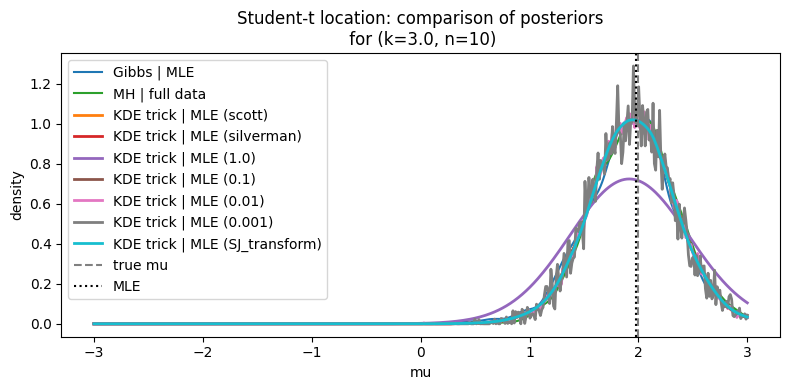

In [10]:
mu_gibbs = gibbs_results["mu_chain"][burnin:]
mu_fulldata = mh_results["mu_chain"][burnin:]

lo = min(mu_gibbs.min(), mu_fulldata.min()) - 0.5
hi = max(mu_gibbs.max(), mu_fulldata.max()) + 0.5
lo, hi = -3, 3
mu_grid = np.linspace(lo, hi, 500)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
kde_gibbs = gaussian_kde(mu_gibbs, bw_method=bw_method)
kde_fulldata = gaussian_kde(mu_fulldata, bw_method=bw_method)
ax.plot(mu_grid, kde_gibbs(mu_grid), color="C0", label="Gibbs | MLE")
ax.plot(mu_grid, kde_fulldata(mu_grid), color="C2", label="MH | full data")

ax.plot(mu_grid, kde_posterior_pdf_scott(mu_grid), color="C1", lw=2, label=f"KDE trick | MLE (scott)")
ax.plot(mu_grid, kde_posterior_pdf_silverman(mu_grid), color="C3", lw=2, label=f"KDE trick | MLE (silverman)")
ax.plot(mu_grid, kde_posterior_pdf_1(mu_grid), color="C4", lw=2, label=f"KDE trick | MLE (1.0)")
ax.plot(mu_grid, kde_posterior_pdf_01(mu_grid), color="C5", lw=2, label=f"KDE trick | MLE (0.1)")
ax.plot(mu_grid, kde_posterior_pdf_001(mu_grid), color="C6", lw=2, label=f"KDE trick | MLE (0.01)")
ax.plot(mu_grid, kde_posterior_pdf_0001(mu_grid), color="C7", lw=2, label=f"KDE trick | MLE (0.001)")
# ax.plot(mu_grid, kde_posterior_t_abram(mu_grid), color="C8", lw=2, label=f"KDE trick | MLE (t_abram)")
ax.plot(mu_grid, kde_posterior_sj_transform(mu_grid), color="C9", lw=2, label=f"KDE trick | MLE (SJ_transform)")


ax.axvline(mu_true, color="gray", ls="--", label="true mu")
ax.axvline(mle, color="black", ls=":", label="MLE")
ax.set_xlabel("mu")
ax.set_ylabel("density")
ax.legend()
ax.set_title(f"Student-t location: comparison of posteriors\n for (k={k}, n={n})")
plt.tight_layout()
plt.show()
